In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from dataclasses import replace
import json
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec, \
    prepare_state_trajectory, aggregate_state_trajectory
from src.analysis.trf import coefs_to_df
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.utils.timit import get_word_metadata

In [41]:
sns.set_theme(style="whitegrid", context="talk", font_scale=2)

In [4]:
dataset = "timit-no_repeats"

base_model = "w2v2_8"
model_class = "rnn_8-aniso2"
model_name = "word_broad"

# base_model = "w2v2_6"
# model_class = "rnn_8-weightdecay0.01"
# model_name = "biphone_pred"

model_dir = f"outputs/models/{dataset}/{base_model}/{model_class}/{model_name}_10frames"
output_dir = f"outputs/notebooks/{dataset}/{base_model}/{model_class}/{model_name}_10frames/state_space"
dataset_path = f"outputs/preprocessed_data/{dataset}"
equivalence_path = f"outputs/equivalence_datasets/{dataset}/{base_model}/{model_name}_10frames/equivalence.pkl"
hidden_states_path = f"outputs/hidden_states/{dataset}/{base_model}/hidden_states.pkl"
state_space_specs_path = f"outputs/state_space_specs/{dataset}/{base_model}/state_space_specs.pkl"
embeddings_path = f"outputs/model_embeddings/{dataset}/{base_model}/{model_class}/{model_name}_10frames/embeddings.npy"

subjects = ["EC196", "EC212", "EC260"]
encoder_name = "word_broad-aniso2-w2v2_8"
# encoder_name = "biphone_pred"
encoder_dirs = {subject: Path(f"outputs/encoders/{dataset}") / encoder_name / subject for subject in subjects}

metric = "cosine"

In [5]:
with open(embeddings_path, "rb") as f:
    model_representations: np.ndarray = np.load(f)
with open(state_space_specs_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = torch.load(f)["word"]
assert state_space_spec.is_compatible_with(model_representations)

In [6]:
encoders = {subject: torch.load(encoder_dir / "model.pkl") for subject, encoder_dir in encoder_dirs.items()}
electrode_df = pd.concat([pd.read_csv(encoder_dir / "electrodes.csv", index_col="electrode_idx") for encoder_dir in encoder_dirs.values()],
                         keys=subjects, names=["subject", "electrode_idx"])

In [7]:
coefs, model_embedding_coefs = {}, {}
electrode_names = {}
coef_dfs = {}
for subject, encoder_dir in tqdm(encoder_dirs.items()):
    num_fit_electrodes = encoders[subject].coef_.shape[0]
    electrode_names[subject] = electrode_df.loc[subject].head(num_fit_electrodes).electrode_name

    coefs_i = np.stack(torch.load(encoder_dir / "coefs.pkl"))
    coefs[subject] = coefs_i
    model_embedding_coefs[subject] = coefs_i[:, :, [idx for idx, name in enumerate(encoders[subject].feature_names)
                                                    if name.startswith("model_embedding")]]

    coef_dfs[subject] = coefs_to_df(coefs_i, encoders[subject].feature_names,
                                    electrode_names[subject], encoders[subject].sfreq)

  0%|          | 0/3 [00:00<?, ?it/s]

## Embedding PCA analysis

In [8]:
# use words with at least N instances to compute PCA
pca_min_freq = 20
timit_word_freqs = sorted([(len(trajs), label) for trajs, label in zip(state_space_spec.target_frame_spans, state_space_spec.labels)], reverse=True)
pca_words = [label for count, label in timit_word_freqs if count >= pca_min_freq]

# drop_idxs = [idx for idx, word in enumerate(state_space_spec.labels)
#              if word not in pca_words]
# state_space_spec = state_space_spec.drop_labels(drop_idxs)

In [9]:
len(state_space_spec.labels)

6100

In [10]:
trajectory = prepare_state_trajectory(
    model_representations,
    state_space_spec,
    pad=np.nan
)

In [11]:
trajectory = aggregate_state_trajectory(trajectory, "mean", keepdims=True)

In [12]:
all_trajectories_full = np.concatenate(trajectory)
all_trajectories_src = np.concatenate([
    np.stack([np.ones(traj_i.shape[0]) * idx, np.arange(traj_i.shape[0])]).T
    for idx, traj_i in enumerate(trajectory)
]).astype(int)

# flatten & retain non-padding
all_trajectories = all_trajectories_full.reshape(-1, all_trajectories_full.shape[-1])
retain_idxs = ~np.isnan(all_trajectories).any(axis=1)
all_trajectories = all_trajectories[retain_idxs]
all_trajectories_src = all_trajectories_src[retain_idxs]

# for PCA estimation, retain only those words with at least `pca_min_freq`

# retain just `pca_min_freq` instances of each word for PCA estimation, to make sure the space
# is not biased for frequent words
retain_idxs_estimation = []
for label_idx in range(len(trajectory)):
    traj_idxs = np.where(all_trajectories_src[:, 0] == label_idx)[0]
    retain_idxs_estimation.append(np.random.choice(
        traj_idxs, min(len(traj_idxs), pca_min_freq), replace=False))
retain_idxs_estimation = np.concatenate(retain_idxs_estimation)
all_trajectories_estimation = all_trajectories[retain_idxs_estimation]
all_trajectories_src_estimation = all_trajectories_src[retain_idxs_estimation]

In [13]:
pca = PCA(n_components=4)
pca.fit(all_trajectories_estimation)

all_trajectories_pca = pca.transform(all_trajectories)

In [14]:
pca.explained_variance_ratio_

array([9.12937591e-01, 8.55548408e-02, 6.80515027e-04, 2.93919626e-04])

In [15]:
pca_coefs = {subject: pca.transform(model_coefs_i.transpose((0, 1, 3, 2)).reshape((-1, 8))) \
    .reshape(model_coefs_i.shape[:2] + (61, pca.n_components_)).transpose((0, 1, 3, 2))
    for subject, model_coefs_i in model_embedding_coefs.items()}
pca_coefs = {subject: pca_coefs_i - pca_coefs_i[:, :, :, :1] for subject, pca_coefs_i in pca_coefs.items()}
{subject: c.shape for subject, c in pca_coefs.items()}

{'EC196': (3, 256, 4, 61), 'EC212': (3, 384, 4, 61), 'EC260': (3, 256, 4, 61)}

In [85]:
pca_coef_df = pd.concat({
    subject: coefs_to_df(
        pca_coefs_i, [f"PC {i + 1}" for i in range(pca.n_components_)],
        electrode_names[subject], encoders[subject].sfreq)
    for subject, pca_coefs_i in pca_coefs.items()
    }, names=["subject"]).reset_index()
pca_coef_df["electrode_label"] = pca_coef_df.subject.str.cat(pca_coef_df.output_dim.astype(str), sep="_")

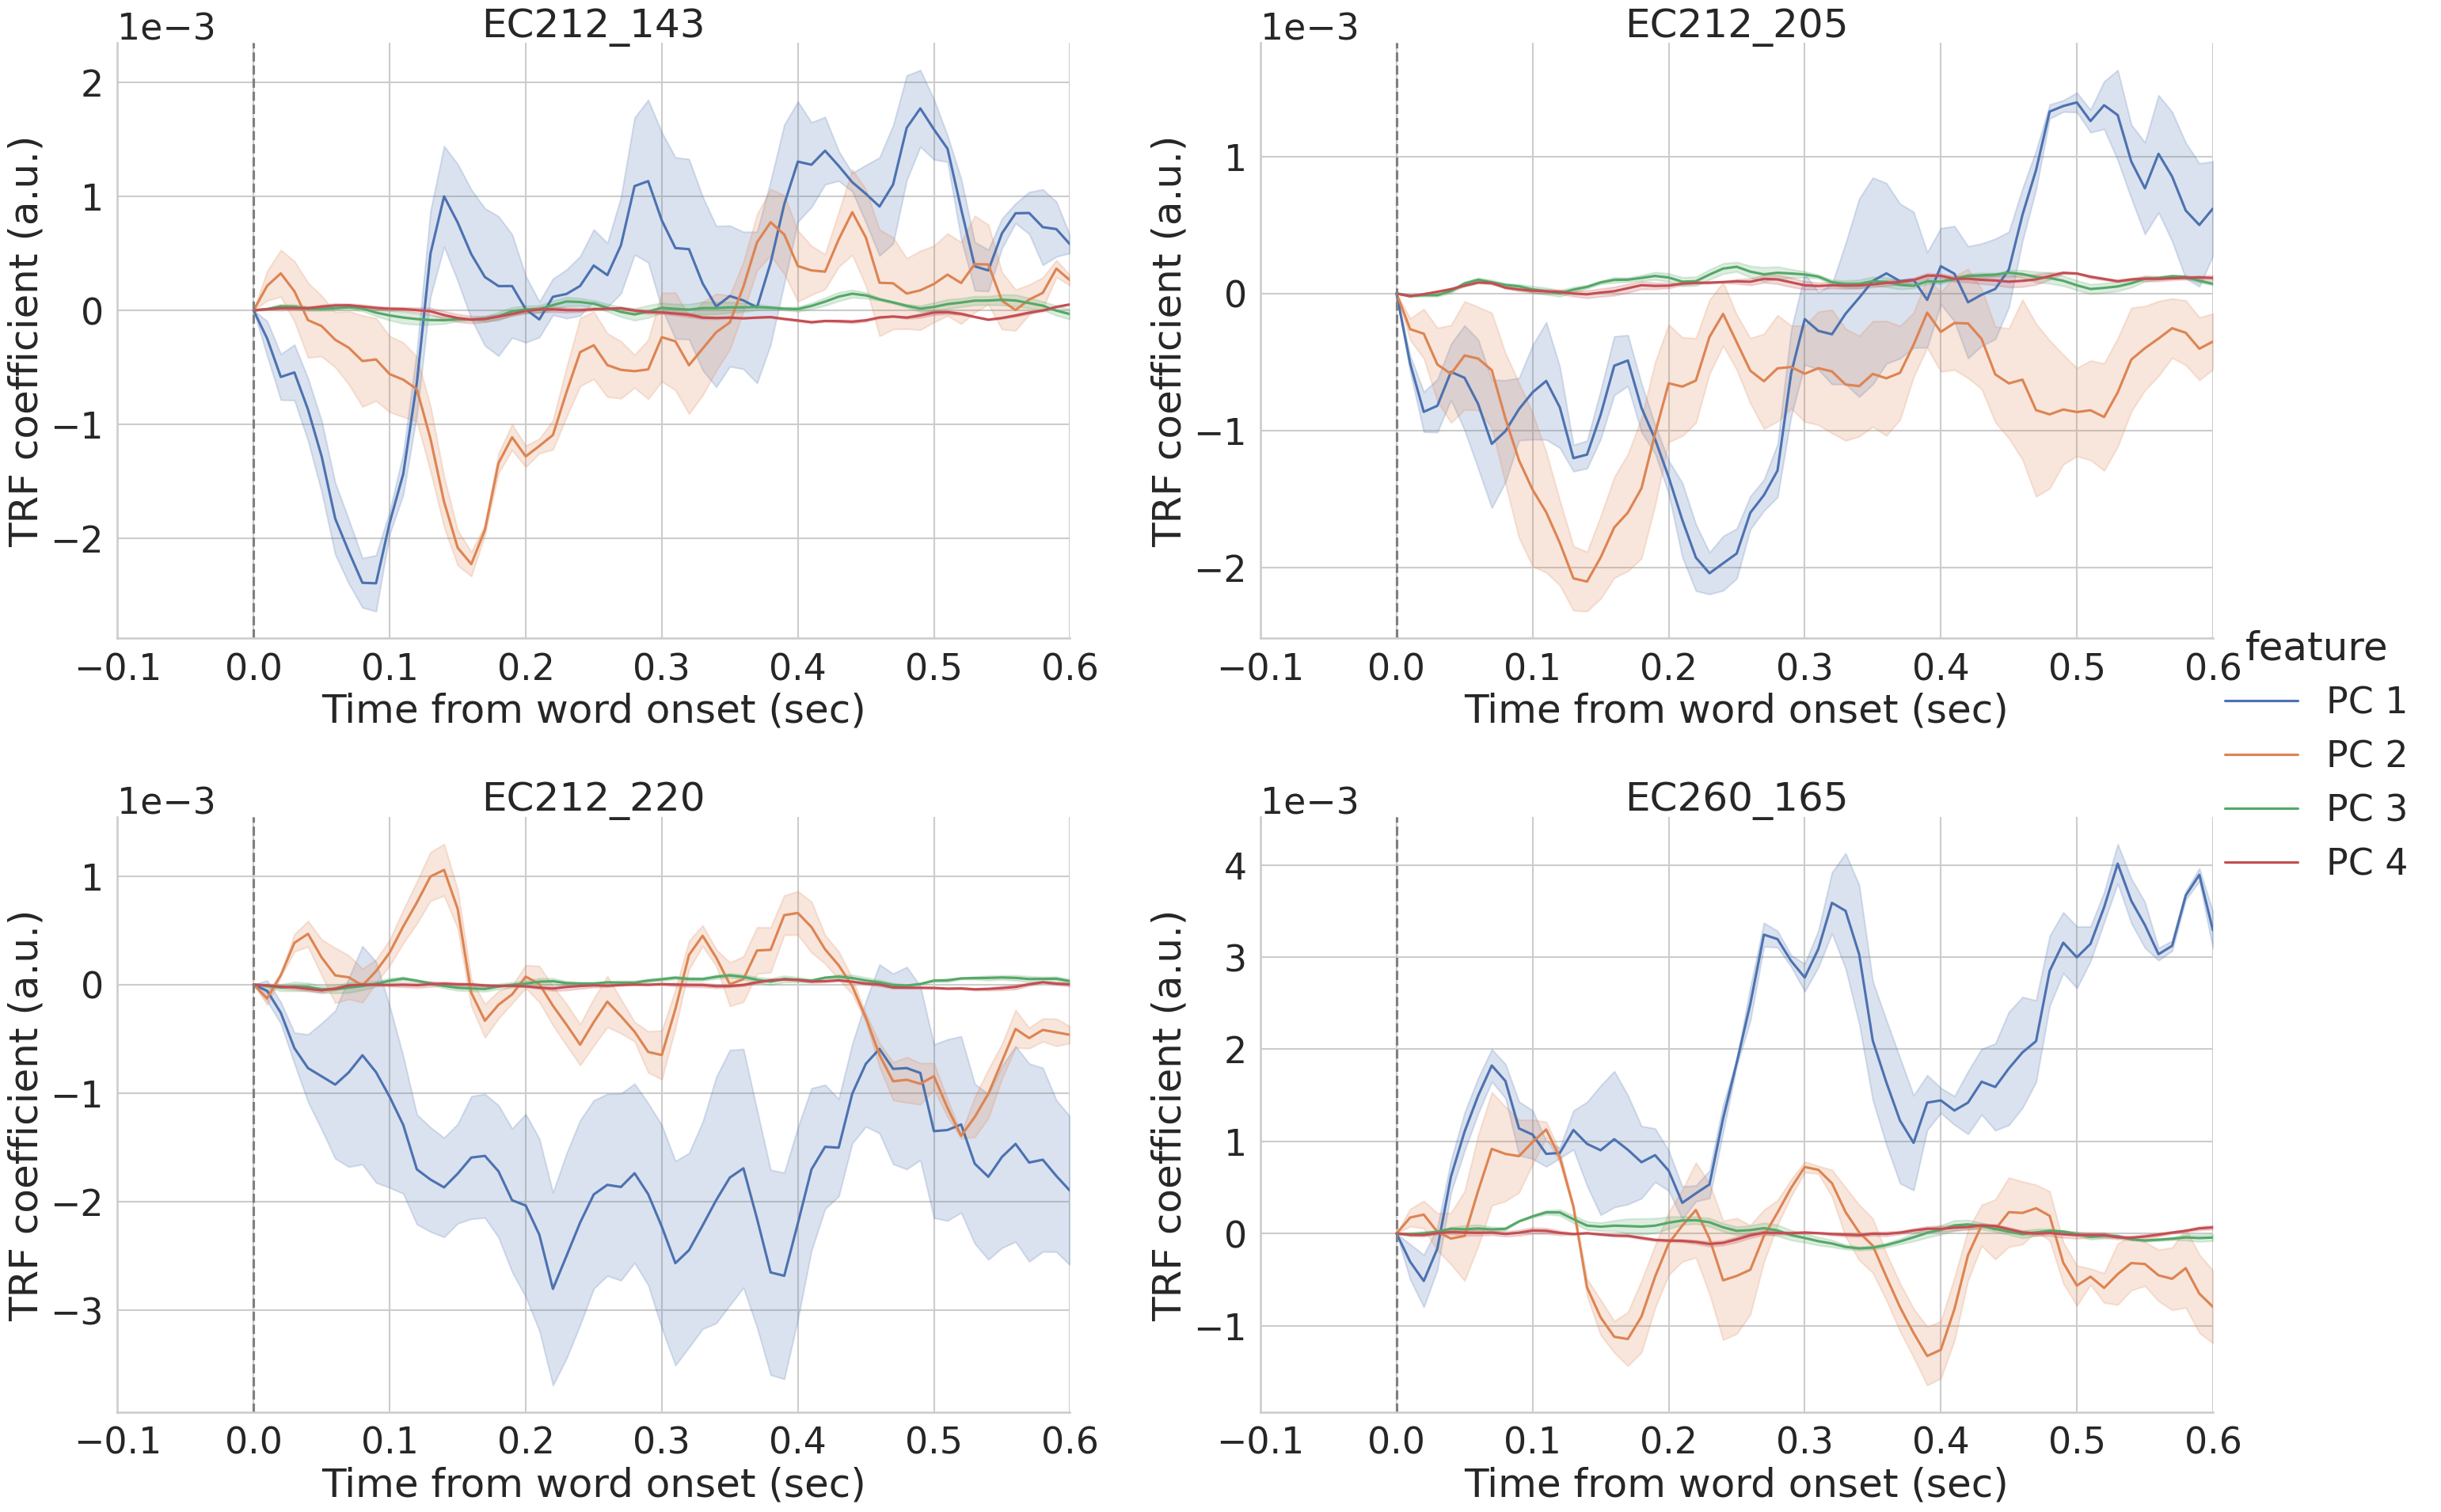

In [103]:
# plot word-dominant electrodes in PC space
# word_dominant = sorted([f"EC212_{dim}" for dim in [220, 214, 107, 74, 114, 211]] + \
#     [f"EC196_{dim}" for dim in [185, 233, 8]] + \
#     [f"EC260_{dim}" for dim in [3, 84, 92, 126, 208, 210, 216]])
# word-dominant according to estimation on timit-no_repeats
#, 143, 368, 369, 252, 344, 123, 297, 159, 66])] + \
word_dominant = \
    [f"EC212_{dim}" for dim in sorted([220, 205, 143])] + \
    [f"EC260_{dim}" for dim in sorted([165])]
hue_order = [f"PC {i + 1}" for i in range(pca.n_components_)]
col_order = word_dominant
g = sns.relplot(data=pca_coef_df[pca_coef_df.electrode_label.isin(word_dominant)],
                col="electrode_label", col_wrap=2, col_order=col_order,
                x="time", y="coef",
                hue="feature", hue_order=hue_order,
                kind="line", errorbar="se", height=10, aspect=1.5,
                facet_kws=dict(sharex=False, sharey=False),
                )
plt.subplots_adjust(hspace=0.3, wspace=0.2)

max_points = {}
for (row, col, hue), facet_data in g.facet_data():
    ax = g.facet_axis(row, col)
    ax.set_xlim((-0.1, 0.6))
    ax.set_xlabel("Time from word onset (sec)")
    ax.set_ylabel("TRF coefficient (a.u.)")
    ax.set_title(ax.get_title().replace("electrode_label = ", ""))
    ax.axvline(0, color="gray", linestyle="--")
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

    # for feature, feature_rows in facet_data.groupby("feature"):
    #     facet_means = feature_rows.groupby("time").coef.mean()
    #     max_point = np.abs(facet_means).idxmax()
    #     ax.scatter(max_point, facet_means.loc[max_point], color="red")

    #     output_dim = feature_rows.output_dim.iloc[0]
    #     max_points[output_dim, feature] = max_point

## Understand the PCs

In [17]:
all_trajectories_pca.shape

(41129, 4)

In [102]:
for traj_idx in all_trajectories_pca[:, 0].argsort()[:20]:
    label_idx, instance_idx = all_trajectories_src[traj_idx]
    print(state_space_spec.labels[label_idx], instance_idx, all_trajectories_pca[traj_idx, 0])

tapestry 2 -3.515668582142357
porcupines 1 -3.4951487145350613
process 7 -3.488585007583222
purposeless 0 -3.447538537246653
successors 0 -3.439880304647928
questions 1 -3.438301642544
assistance 5 -3.436542233055295
sacrifice 0 -3.4320957491859194
fingerprints 0 -3.412484751432554
sufficiency 0 -3.4087068557788
sightseers 0 -3.4070693742917757
trousers 0 -3.4037775380017563
circumstances 1 -3.385448476793558
process 1 -3.384875360211704
constructions 0 -3.3843944336989584
complicated 0 -3.36695383082919
assistance 0 -3.363431038897775
coexist 3 -3.3597131876768955
tapestry 3 -3.358141333108824
triumphant 0 -3.3550994485758827


In [101]:
for traj_idx in all_trajectories_pca[:, 0].argsort()[-20:]:
    label_idx, instance_idx = all_trajectories_src[traj_idx]
    print(state_space_spec.labels[label_idx], instance_idx, all_trajectories_pca[traj_idx, 0])

warm 15 3.435550923780751
allow 25 3.4356230535198846
mango 0 3.442089742533943
bayou 0 3.4426255577992615
oasis 6 3.4470149542513586
hallway 5 3.453440137799447
lighted 1 3.456677677732165
highway 5 3.464230706533936
long 30 3.468715763632007
mudwagon 0 3.4854907323880338
ideology 2 3.4891195810260527
alone 4 3.4902490378440785
hallway 3 3.4931320526231358
lawyers 0 3.497238073451592
nevertheless 2 3.5003467258790386
allow 42 3.5044124926270546
hallway 9 3.508242101371196
mango 3 3.596463520023041
allow 45 3.6100327327517494
allow 37 3.6326272917097397


In [20]:
# instance_metadata = state_space_spec.cuts.xs("phoneme", level="level").groupby(["label", "instance_idx"]).head(1) \
#     .rename(columns={"description": "onset_phoneme"})
instance_metadata = get_word_metadata(state_space_spec)
instance_metadata

Missing words:  ['amorist', 'analyticity', 'autofluorescence', 'blastdown', 'boardinghouses', 'bugeyed', 'castorbeans', 'cheetal', 'conformists', 'ellipsoids', "engineers'", 'exhusband', 'fasciculations', 'frowningly', 'geocentricism', 'gyrocompass', 'hypothalamic', 'infuriation', 'keelson', 'longitudes', 'lousiness', 'madstones', "maids'", 'mealynosed', 'micrometeorite', 'micrometeorites', 'misperceives', 'morphophonemic', "motorists'", 'muddleheaded', 'mudwagon', "nan's", 'nonsystematic', "nurses'", "o'", "o'clock", 'octillion', 'overnighters', 'paramagnetic', "pilots'", 'polyesters', 'pompousness', 'radiosterilization', 'redeposition', 'regulative', 'semidrying', 'skywave', 'soysauce', 'sputniks', "students'", 'surfaceness', 'tremulously', 'unmagnified', 'uremia', "veterans'", 'warningly', 'whiplashes', 'zircons']
Word frequency quantile split:
 0.000000    1.159182e+07
0.333333    6.592652e+10
0.666667    2.826317e+12
1.000000    5.526592e+13
Name: word_frequency, dtype: float64
wo

/userdata/jgauthier/projects/ideal-word-representations/src/utils/timit.py:405: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(word_metadata.groupby("word_frequency_quantile").apply(lambda xs: xs.sample(5).index.get_level_values("label").to_list()))


num_syllables  monosyllabic word_freq_lookup  \
label instance_idx item_idx                                                 
'em   0            680                   1          True              'em   
      1            1080                  1          True              'em   
      2            1080                  1          True              'em   
      3            1201                  1          True              'em   
      4            1248                  1          True              'em   
...                                    ...           ...              ...   
zoos  2            206                   1          True             zoos   
      3            1406                  1          True             zoos   
      4            2453                  1          True             zoos   
      5            2670                  1          True             zoos   
      6            3101                  1          True             zoos   

                             word_frequency word_frequency_quantile  \
label instance_idx item_idx                                           
'em   0            680         1.876193e+12                       1   
      1            1080        1.876193e+12                       1   
      2            1080        1.876193e+12                       1   
      3            1201        1.876193e+12                       1   
      4            1248        1.876193e+12                       1   
...                                     ...                     ...   
zoos  2            206         1.321467e+09                       0   
      3            1406        1.321467e+09                       0   
      4            2453        1.321467e+09                       0   
      5            2670        1.321467e+09                       0   
      6            3101        1.321467e+09                       0   

                            onset_phoneme onset_biphone  
label instance_idx item_idx                              
'em   0            680                 AH          AH M  
      1            1080                AH          AH M  
      2            1080                AH          AH M  
      3            1201                AH          AH M  
      4            1248                 M             M  
...                                   ...           ...  
zoos  2            206                  Z          Z UW  
      3            1406                 Z          Z UW  
      4            2453                 Z          Z UW  
      5            2670                 Z          Z UW  
      6            3101                 Z          Z UW  

[41129 rows x 7 columns]

In [21]:
# vowels = ["a", "e", "i", "o", "u", "w", "l", "h", "y"]
pca_1_onsets = ['AH', 'IH', 'EY', 'ER', 'EH', 'HH', 'UH', 'IY', 'W', 
       'AE', 'Y', 'AO', 'AA', 'OW', 'L', 'OY',
       'AW', 'AY', 'UW', 'R',
       "M", "N", "NG", "B", "V", "DH", "G",]
instance_metadata["classifier_label"] = instance_metadata.onset_phoneme.isin(pca_1_onsets)
cmap = sns.color_palette("tab10", n_colors=10)
scatter_colors = [cmap[int(instance_metadata.loc[(state_space_spec.labels[label_idx], instance_idx), "classifier_label"].item())]
                  for label_idx, instance_idx in all_trajectories_src]

In [22]:
instance_df = pd.merge(
    pd.DataFrame(all_trajectories_pca,
        columns=[f"pca_{dim + 1}" for dim in range(pca.n_components_)],
        index=pd.MultiIndex.from_tuples([(state_space_spec.labels[label_idx], instance_idx) for label_idx, instance_idx in all_trajectories_src], names=["label", "instance_idx"])),
    instance_metadata,
    left_index=True, right_index=True, how="left", validate="one_to_one")
# legacy
train_df = instance_df

In [23]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, KFold

In [26]:
# from collections import Counter
# timit_dataset = datasets.load_from_disk("outputs/preprocessed_data/timit")
# repeat_texts = [text for text, _ in Counter(timit_dataset["text"]).most_common(2)]
# repeat_item_idxs = [idx for idx, text in enumerate(timit_dataset["text"]) if text in repeat_texts]
# # don't include repeat sentences in PCA evaluation
# train_df = instance_df.loc[~instance_df.index.get_level_values("item_idx").isin(repeat_item_idxs)]

In [24]:
# attempt to predict sonorant-ness of onset from PCA 1
X = train_df.pca_1.to_numpy()[:, None]
y = train_df.classifier_label

clf = LogisticRegressionCV(cv=KFold(5, shuffle=True), max_iter=1000)
clf.fit(X, y)
clf_scores = cross_val_score(clf, X, y, cv=KFold(5, shuffle=True), scoring="roc_auc")
print(clf_scores)
print(clf_scores.mean())

[0.96384075 0.95991796 0.95732621 0.96028708 0.9619311 ]
0.9606606202010909


In [25]:
train_df["log_word_frequency"] = np.log10(train_df.word_frequency)

In [26]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
# cross_val_score(LogisticRegressionCV(cv=KFold(5, shuffle=True)),
#                 train_df.pca_1.to_numpy()[:, None], (train_df.monosyllabic).to_numpy(),
#                 cv=KFold(5, shuffle=True), scoring="roc_auc")

cross_val_score(RidgeCV(cv=KFold(5, shuffle=True)),
                StandardScaler().fit_transform(train_df[["pca_2"]].to_numpy()),
                StandardScaler().fit_transform(train_df.log_word_frequency.to_numpy()[:, None])[:, 0],
                cv=KFold(5, shuffle=True))

array([0.17509261, 0.19154323, 0.19115162, 0.18083986, 0.1774016 ])

In [78]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
# cross_val_score(LogisticRegressionCV(cv=KFold(5, shuffle=True)),
#                 train_df.pca_1.to_numpy()[:, None], (train_df.monosyllabic).to_numpy(),
#                 cv=KFold(5, shuffle=True), scoring="roc_auc")

print("variance explained in PC 2 from log word frequency")
r2_scores = cross_val_score(RidgeCV(cv=KFold(5, shuffle=True)),
                StandardScaler().fit_transform(train_df.log_word_frequency.to_numpy()[:, None]),
                StandardScaler().fit_transform(train_df[["pca_2"]].to_numpy()),
                cv=KFold(5, shuffle=True))
print(r2_scores)
print(r2_scores.mean())

variance explained in PC 2 from log word frequency
[0.1782357  0.17818842 0.18821676 0.19055771 0.18159617]
0.183358950513486


In [77]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
# cross_val_score(LogisticRegressionCV(cv=KFold(5, shuffle=True)),
#                 train_df.pca_1.to_numpy()[:, None], (train_df.monosyllabic).to_numpy(),
#                 cv=KFold(5, shuffle=True), scoring="roc_auc")

print("variance explained in PC 1 from log word frequency")
r2_scores = cross_val_score(RidgeCV(cv=KFold(5, shuffle=True)),
                StandardScaler().fit_transform(train_df.log_word_frequency.to_numpy()[:, None]),
                StandardScaler().fit_transform(train_df[["pca_1"]].to_numpy()),
                cv=KFold(5, shuffle=True))
print(r2_scores)
print(r2_scores.mean())

variance explained in PC 1 from log word frequency
[0.08150148 0.08547466 0.07493738 0.08063999 0.08555532]
0.08162176704951832


In [31]:
# explain variance in PC 1 from sonorant-ish label
cross_val_score(RidgeCV(cv=KFold(5, shuffle=True)),
                train_df.classifier_label.astype(int).to_numpy()[:, None],
                StandardScaler().fit_transform(train_df.pca_1.to_numpy()[:, None])[:, 0],
                cv=KFold(5, shuffle=True)).mean()

0.6337418290439712

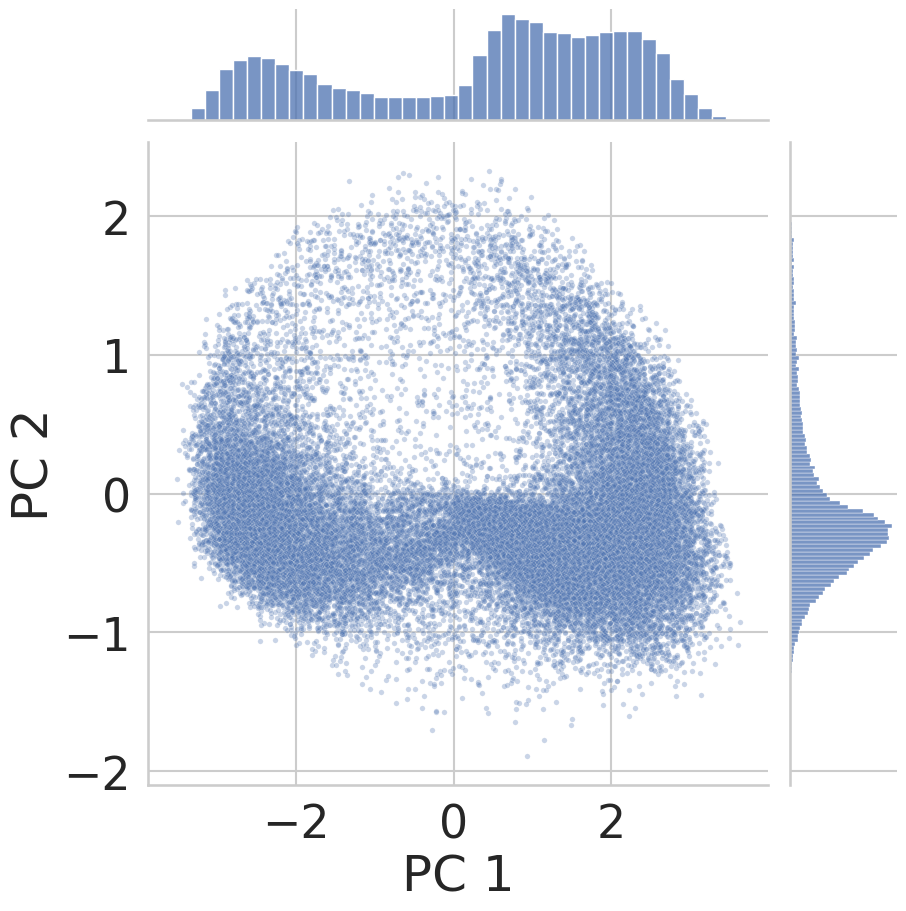

In [57]:
sns.jointplot(data=train_df.rename(columns={"pca_1": "PC 1", "pca_2": "PC 2"}),
              x="PC 1", y="PC 2", height=10,
              joint_kws=dict(alpha=0.3, s=15))

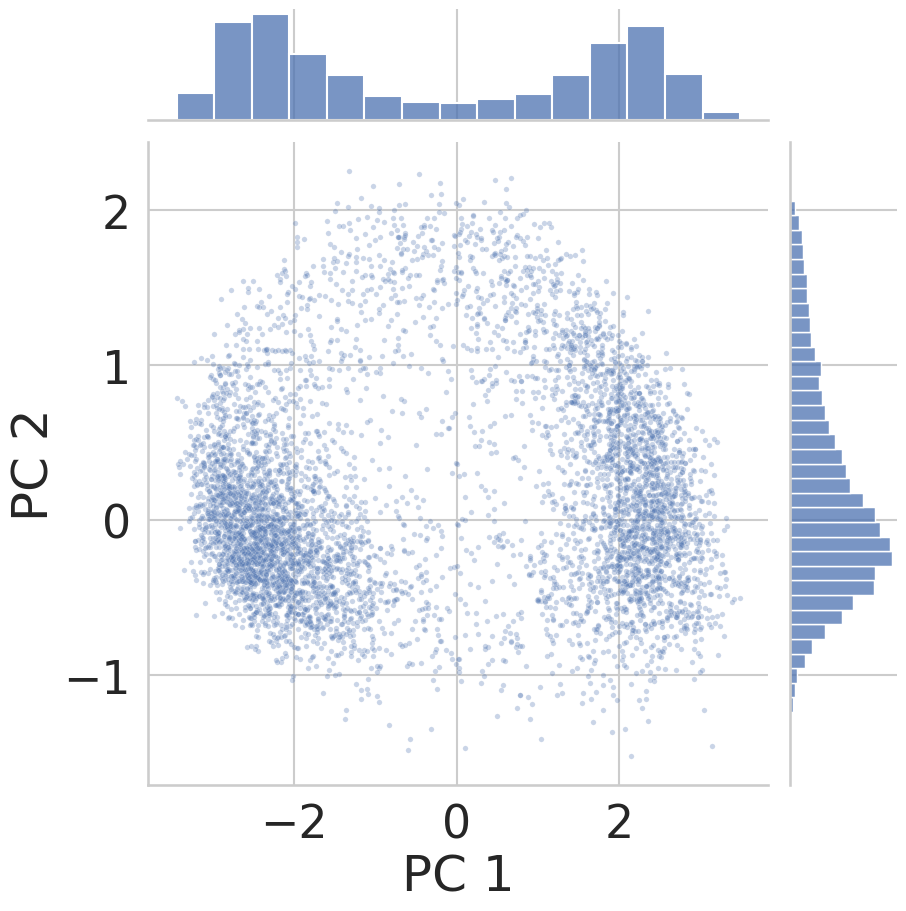

In [58]:
sns.jointplot(data=train_df.groupby("label")[["pca_1", "pca_2"]].mean().rename(columns={"pca_1": "PC 1", "pca_2": "PC 2"}),
              x="PC 1", y="PC 2", height=10,
              joint_kws=dict(alpha=0.3, s=15))

In [29]:
sample_pts = np.linspace(instance_df.pca_1.min(), instance_df.pca_1.max(), 100)
decision_boundary = sample_pts[((clf.predict_proba(sample_pts[:, None])[:, 0] - 0.5) ** 2).argmin()]
decision_boundary

-0.5552632202440133

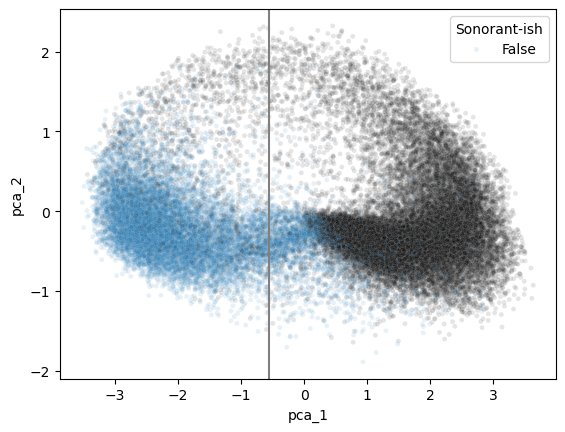

In [30]:
ax = sns.scatterplot(data=train_df.rename(columns={"classifier_label": "Sonorant-ish"}),
                     x="pca_1", y="pca_2", hue="Sonorant-ish", s=12, alpha=0.1)
ax.axvline(decision_boundary, color="gray")

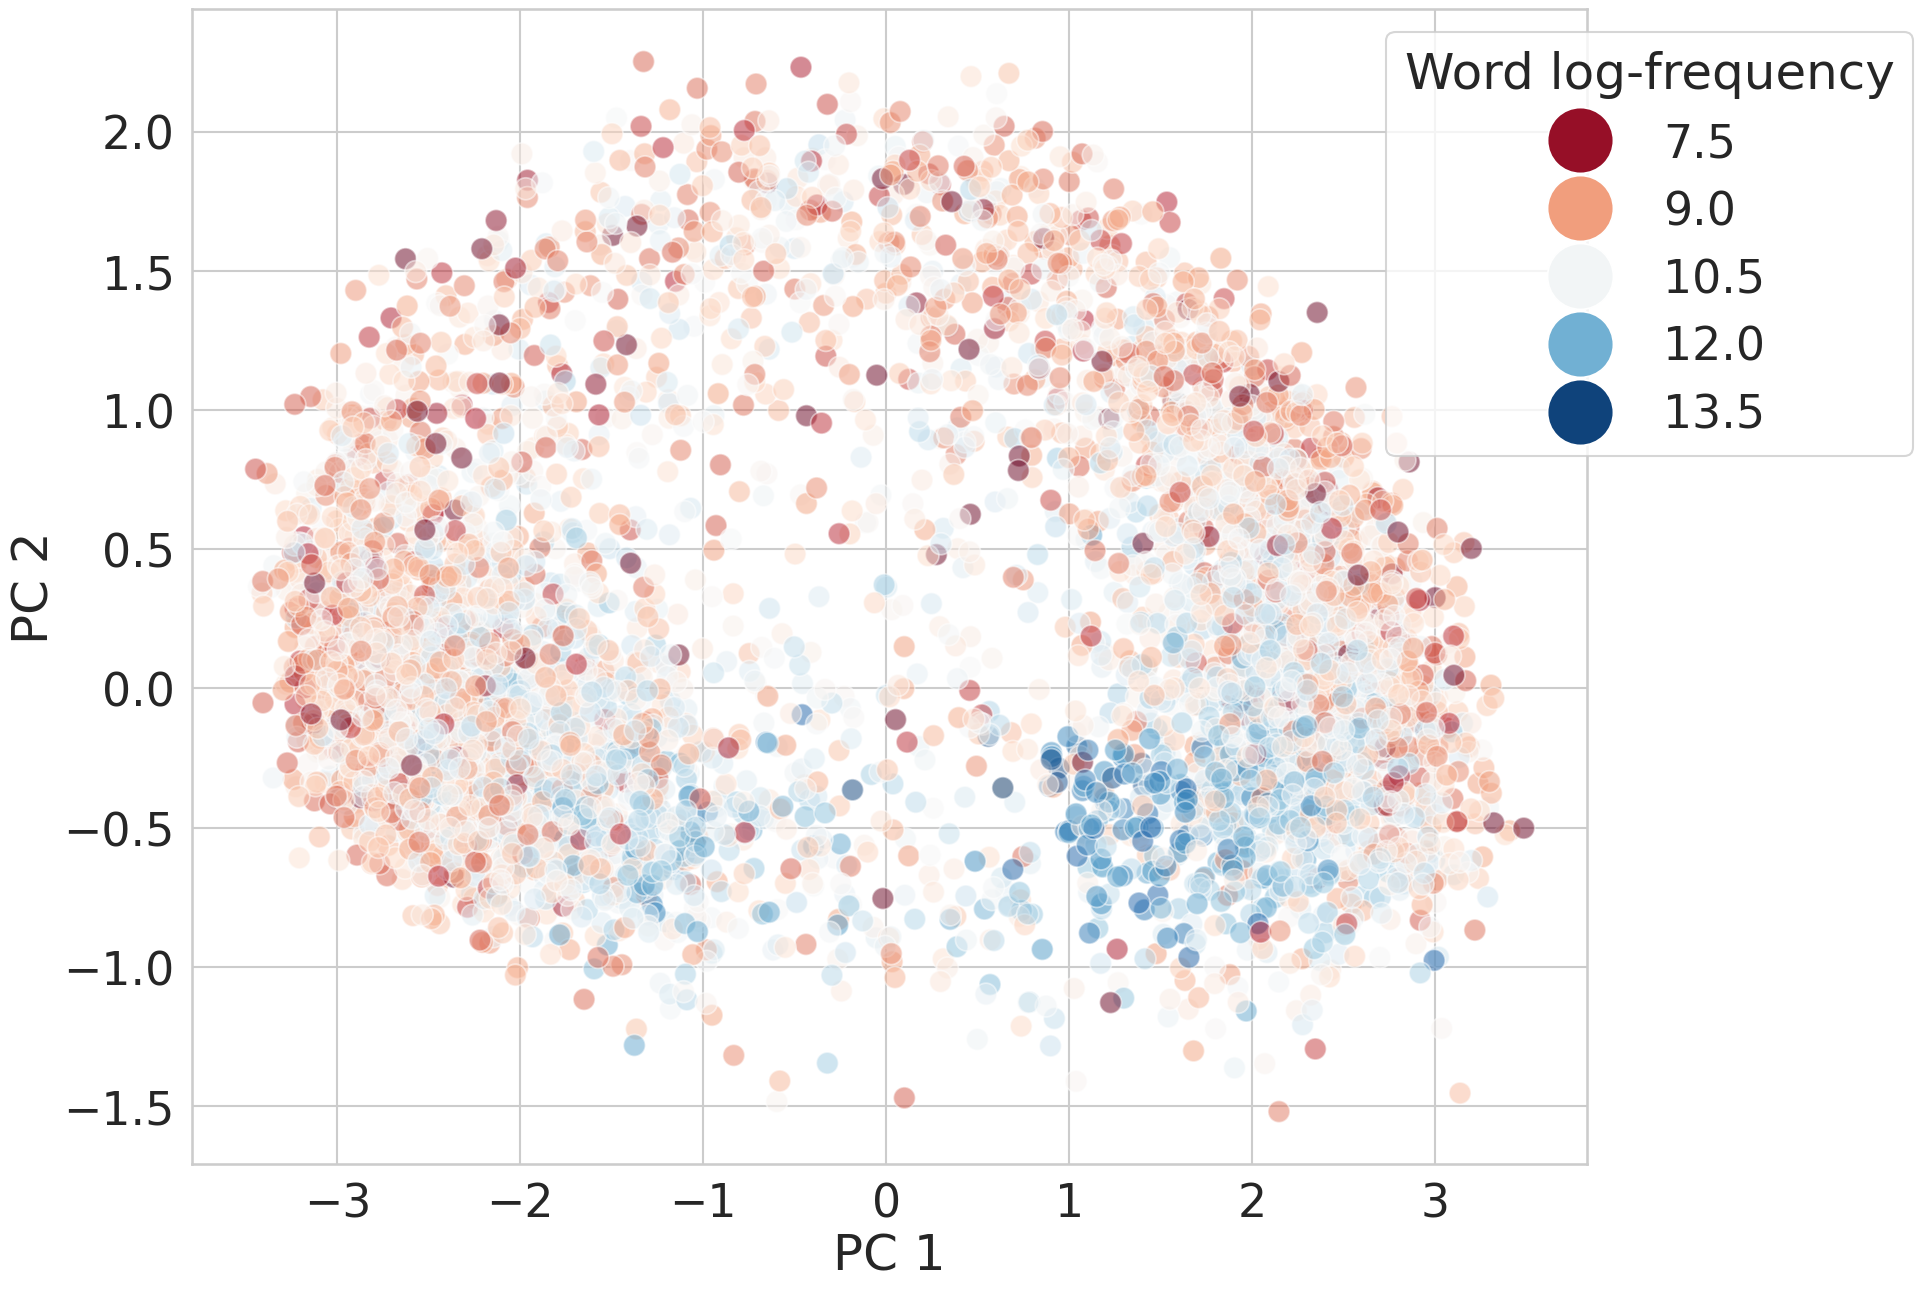

In [111]:
f, ax = plt.subplots(figsize=(18, 15))
sns.scatterplot(data=train_df.rename(columns={"pca_1": "PC 1", "pca_2": "PC 2", "log_word_frequency": "Word log-frequency"})
                        .groupby(["label", "Word log-frequency"])[["PC 1", "PC 2"]].mean().reset_index(),
                x="PC 1", y="PC 2", hue="Word log-frequency", alpha=0.5, s=250, palette="RdBu", ax=ax)
legend = ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1), title="Word log-frequency",
                   markerscale=3)
for lh in legend.legend_handles:
    lh.set_alpha(1.)

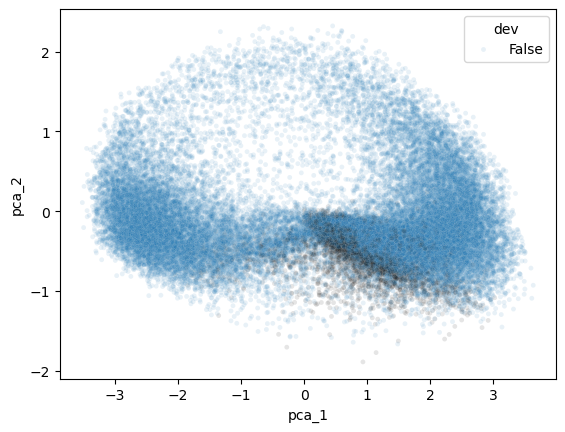

In [36]:
pca1_targets = ("don't", "did", "this", "didn't", "these", "do", "does", "it", "be",
                "then", "is", "he", "she", "get", "the", "into", "we", "a", "needs", "need",
                "used", "take", "use", "those", "took", "it's", "eat", "eating",
                "his", "can", "their", "any", "her", "got", "been", "could", "make", "makes",
                "come", "came", "they", "has")
train_df["dev"] = train_df.index.get_level_values("label").isin(
    pca1_targets)
ax = sns.scatterplot(data=train_df, x="pca_1", y="pca_2", hue="dev", s=12, alpha=0.1)

In [37]:
inspect = train_df.groupby("label").pca_2.agg(["mean", "std"]).sort_values("mean")
inspect = inspect[~inspect.index.isin(pca1_targets)]
inspect.head(20)

mean       std
label                         
ghettos    -1.519661       NaN
establish  -1.483792       NaN
daydreamed -1.470488       NaN
ingenuity  -1.453333       NaN
define     -1.411073       NaN
terrier    -1.409647       NaN
diet       -1.362923       NaN
addressed  -1.347471       NaN
together   -1.345647  0.140893
pansies    -1.317672       NaN
dyeing     -1.301707       NaN
betide     -1.294784       NaN
dad        -1.283833  0.114660
today'll   -1.281656       NaN
debut      -1.260158       NaN
disliked   -1.223049       NaN
donate     -1.222541       NaN
knees      -1.220996       NaN
dew        -1.212915  0.365317
downtown   -1.207946       NaN

In [38]:
from scipy.stats import spearmanr, pearsonr
pearsonr(train_df.pca_2, train_df.log_word_frequency)

PearsonRResult(statistic=-0.4282595138622742, pvalue=0.0)

In [39]:
train_df[(~train_df.dev) & (train_df.pca_1 < 0)].sort_values("pca_2").head(20)

pca_1     pca_2     pca_3     pca_4  \
label     instance_idx item_idx                                           
possessed 0            2481     -0.223000 -1.577355  0.031329 -0.050555   
thought   8            3688     -0.128919 -1.570651  0.039261  0.030766   
dig       2            4449     -0.220341 -1.567555 -0.042058 -0.010831   
die       1            745      -0.730423 -1.508253 -0.001799 -0.018042   
establish 0            4576     -0.598017 -1.483792  0.034326 -0.041794   
deadline  0            71       -0.382415 -1.457448  0.077728 -0.027594   
daphne's  2            4478     -0.924966 -1.427889  0.040959 -0.052514   
terrier   0            89       -0.581959 -1.409647 -0.079444  0.028936   
say       8            2930     -0.496181 -1.406319  0.089660  0.039303   
dishes    3            4086     -1.067103 -1.405597 -0.069020  0.004764   
seemed    5            1816     -0.254924 -1.387397  0.001739 -0.012520   
stag      5            3478     -1.159039 -1.374971  0.028312 -0.068307   
dolphins  0            1597     -0.254072 -1.368856  0.087803 -0.042621   
healthier 6            5028     -0.164946 -1.363964  0.012085 -0.022595   
survive   2            205      -0.296629 -1.362771 -0.011036  0.044778   
dolphins  4            2645     -0.399283 -1.347930  0.126371 -0.045653   
sing      6            2622     -0.854715 -1.345672  0.001994 -0.034297   
deadline  3            1839     -0.728621 -1.339759  0.037062 -0.019738   
sing      4            1974     -0.222366 -1.329702 -0.018405 -0.022961   
dishes    2            3774     -1.108155 -1.320399 -0.067308  0.012211   

                                 num_syllables  monosyllabic word_freq_lookup  \
label     instance_idx item_idx                                                 
possessed 0            2481                  2         False        possessed   
thought   8            3688                  1          True          thought   
dig       2            4449                  2         False              dig   
die       1            745                   1          True              die   
establish 0            4576                  3         False        establish   
deadline  0            71                    2         False         deadline   
daphne's  2            4478                  2         False           daphne   
terrier   0            89                    3         False          terrier   
say       8            2930                  1          True              say   
dishes    3            4086                  2         False           dishes   
seemed    5            1816                  1          True           seemed   
stag      5            3478                  1          True             stag   
dolphins  0            1597                  2         False         dolphins   
healthier 6            5028                  3         False        healthier   
survive   2            205                   2         False          survive   
dolphins  4            2645                  2         False         dolphins   
sing      6            2622                  2         False             sing   
deadline  3            1839                  2         False         deadline   
sing      4            1974                  1          True             sing   
dishes    2            3774                  2         False           dishes   

                                 word_frequency word_frequency_quantile  \
label     instance_idx item_idx                                           
possessed 0            2481        4.787420e+09                       0   
thought   8            3688        5.153374e+11                       1   
dig       2            4449        2.952436e+10                       0   
die       1            745         1.171585e+11                       1   
establish 0            4576        1.899899e+10                       0   
deadline  0            71          3.268892e+10                       0   
da

In [40]:
train_df.to_csv("20240510-train_df.csv")

In [61]:
instance_df["classifier_dec"] = clf.decision_function(instance_df.pca_1.to_numpy()[:, None])
instance_df['classifier_proba'] = clf.predict_proba(instance_df.pca_1.to_numpy()[:, None])[:, 0]
instance_df["classifier_output"] = instance_df.classifier_dec < 0

train_df["classifier_dec"] = clf.decision_function(train_df.pca_1.to_numpy()[:, None])
train_df['classifier_proba'] = clf.predict_proba(train_df.pca_1.to_numpy()[:, None])[:, 0]
train_df["classifier_output"] = train_df.classifier_dec < 0

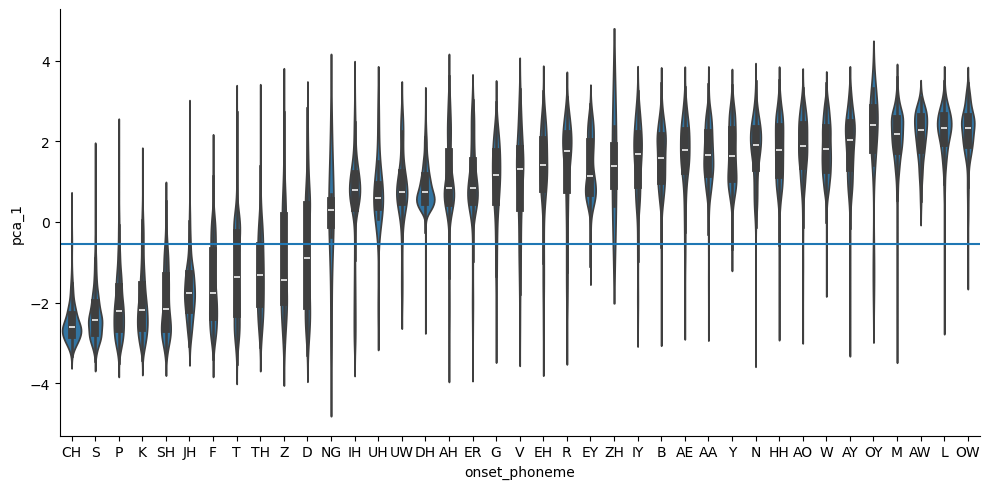

In [42]:
g = sns.catplot(data=train_df, x="onset_phoneme", y="pca_1", kind="violin",
                order=train_df.groupby("onset_phoneme").pca_1.mean().sort_values().index, aspect=2)
g.axes.flat[0].axhline(decision_boundary)

In [43]:
diverse_pca1 = train_df.groupby(["onset_phoneme"]).classifier_output.mean().sort_values()
diverse_pca1 = diverse_pca1[diverse_pca1.between(0.5 - 0.1, 0.5 + 0.1)]
diverse_pca1

onset_phoneme
D    0.550355
Name: classifier_output, dtype: float64

In [44]:
train_df.groupby("onset_phoneme").pca_1.agg(["mean", "std"]).sort_values("mean").dropna()

mean       std
onset_phoneme                    
CH            -2.494743  0.503516
S             -2.310694  0.616404
P             -2.078830  0.775031
K             -2.007712  0.836243
SH            -1.975994  0.832906
JH            -1.675553  0.768098
F             -1.563490  0.960703
T             -1.275190  1.152152
TH            -1.259894  0.994941
Z             -0.981825  1.327477
D             -0.804706  1.417241
NG             0.077888  1.488686
IH             0.498229  1.301014
UH             0.685535  0.953423
UW             0.797480  0.931950
DH             0.876121  0.526204
AH             0.902451  1.269499
ER             0.919144  1.097722
G              0.995553  1.052776
V              1.027452  1.250060
EH             1.218175  1.190696
R              1.306390  1.280916
EY             1.341921  0.768828
ZH             1.390688  1.392912
IY             1.479239  1.041792
B              1.489116  0.901148
AE             1.624492  0.938345
AA             1.647747  0.757823
Y              1.674646  0.747084
N              1.720343  0.901805
HH             1.741796  0.793963
AO             1.786279  0.878787
W              1.798949  0.696953
AY             1.855211  0.863646
OY             2.029025  1.314480
M              2.083445  0.713356
AW             2.147182  0.591649
L              2.191495  0.718529
OW             2.206610  0.658218

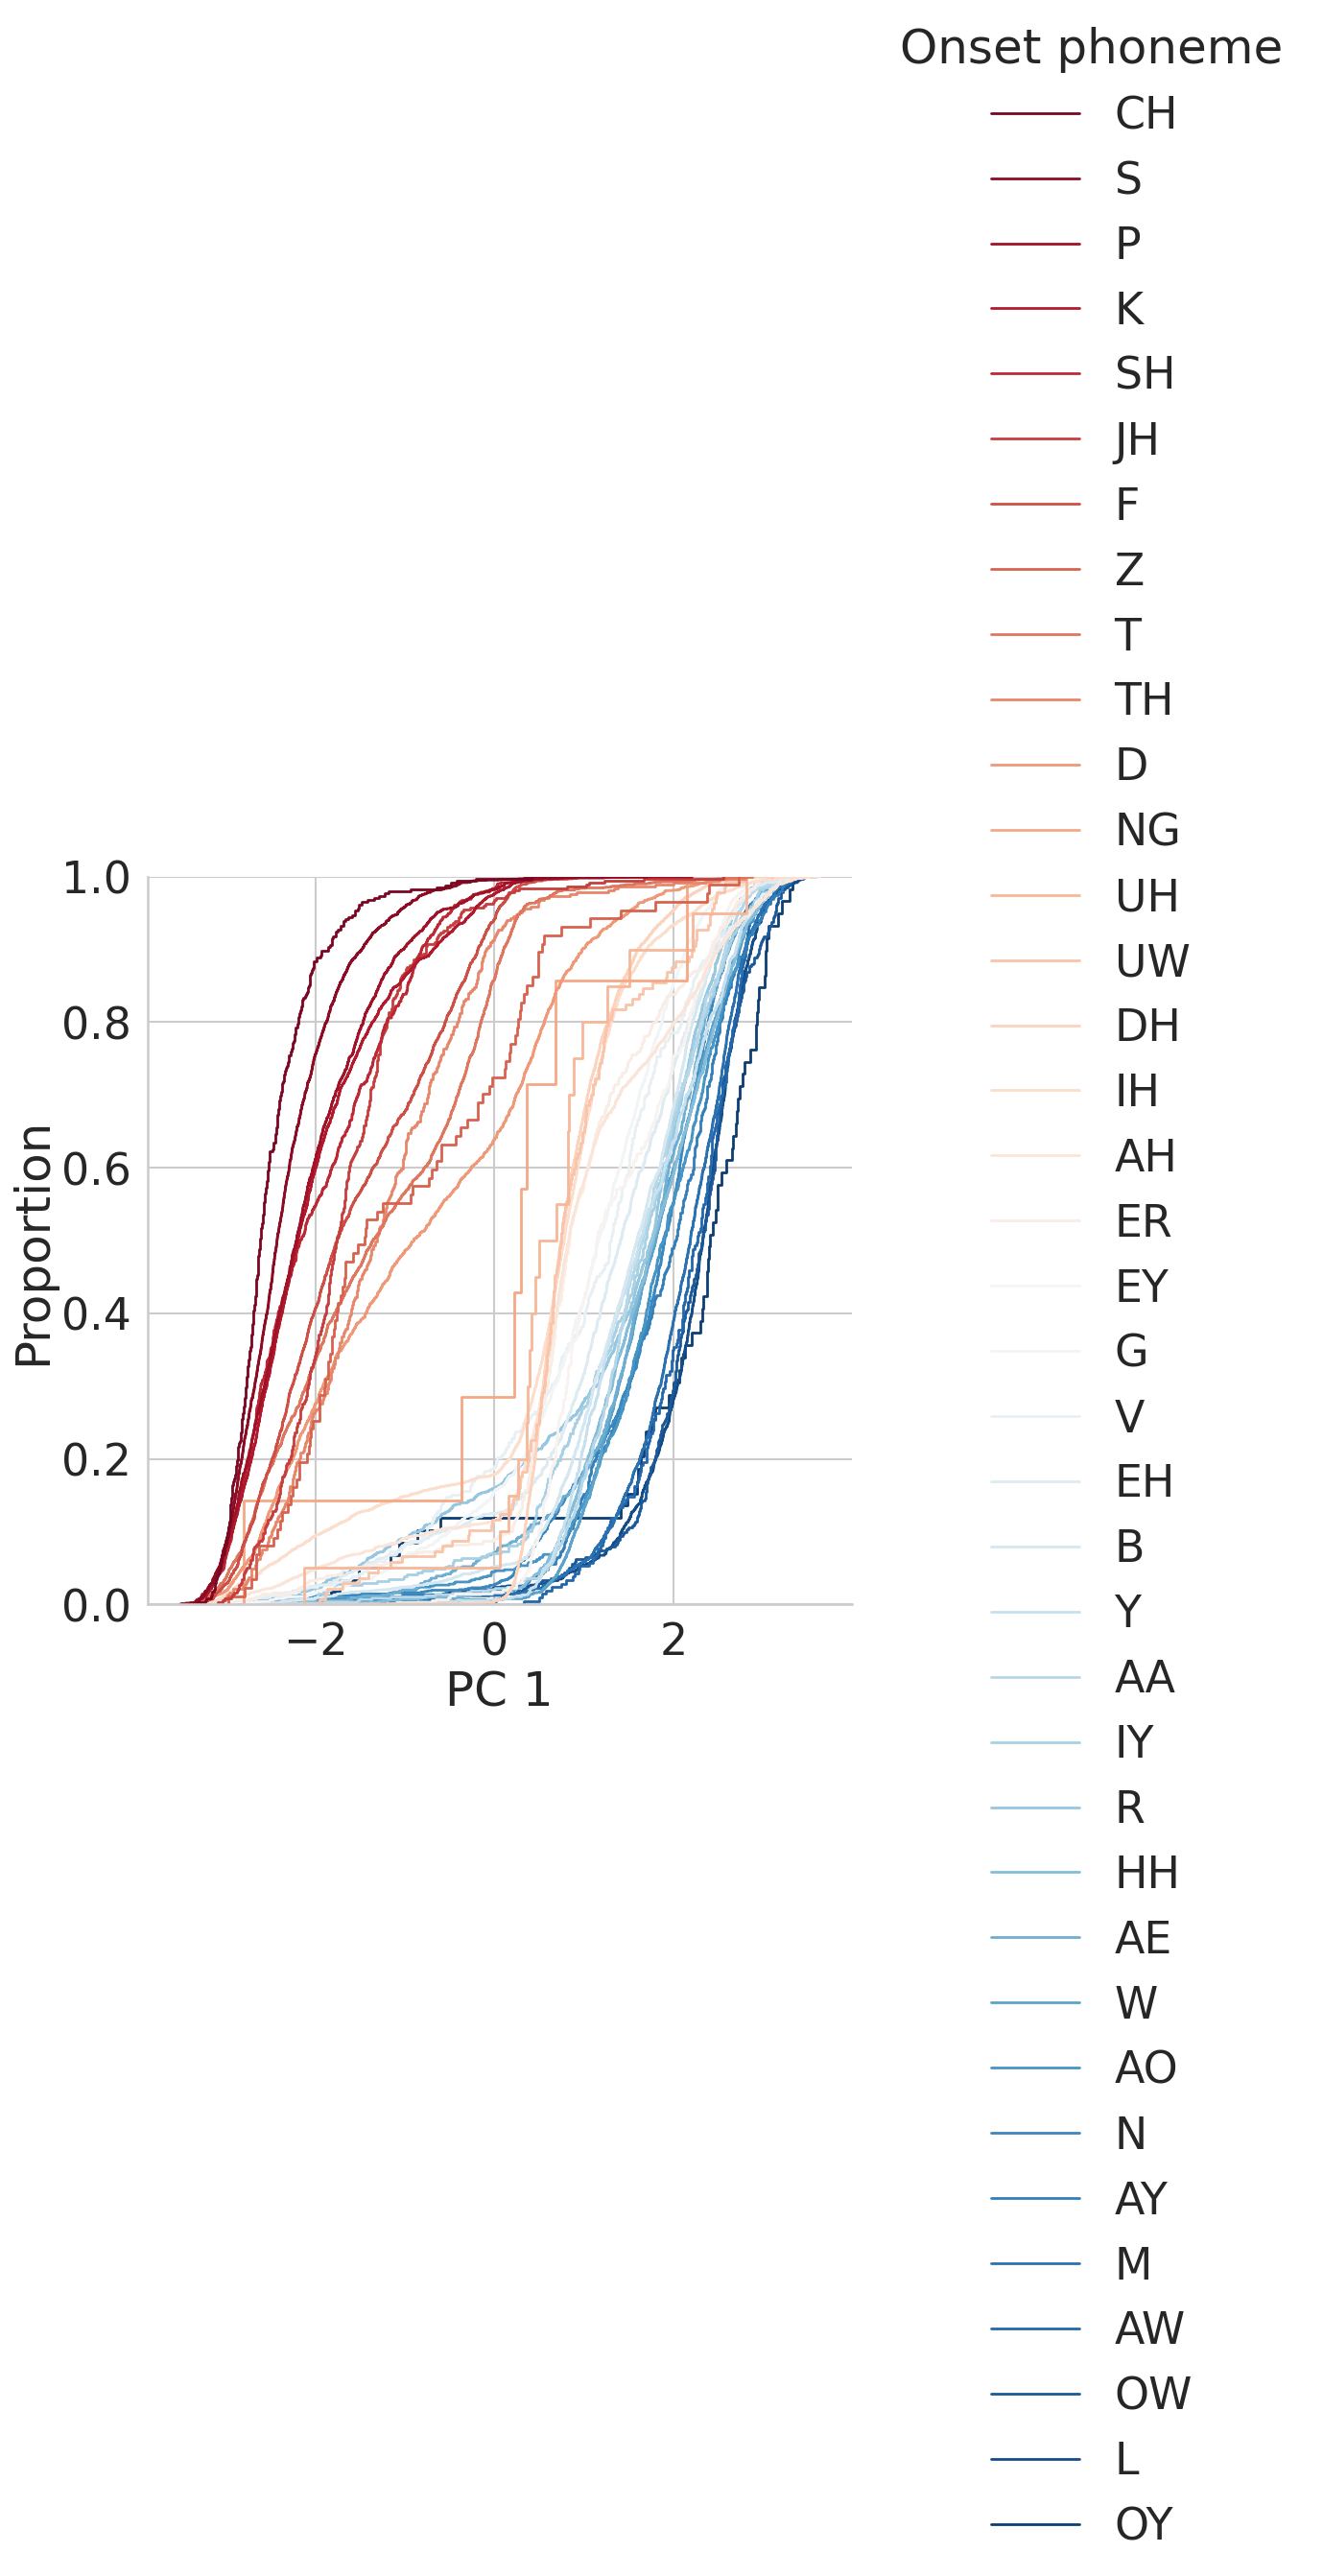

In [75]:
sns.displot(data=train_df[train_df.onset_phoneme != "ZH"].rename(columns={"pca_1": "PC 1", "onset_phoneme": "Onset phoneme"}),
            x="PC 1", hue="Onset phoneme", kind="ecdf",
            hue_order=train_df[train_df.onset_phoneme != "ZH"].groupby("onset_phoneme").pca_1.median().sort_values().index,
            palette="RdBu", height=10, linewidth=2)

In [46]:
train_df.loc["shoes"]

pca_1     pca_2     pca_3     pca_4  num_syllables  \
instance_idx item_idx                                                          
0            374      -1.155261 -0.130902 -0.055960  0.110166              1   
1            421      -2.771002 -0.362397  0.026847  0.022932              1   
2            436      -2.990441 -0.506568  0.019687  0.033759              1   
3            798      -1.515098 -0.131565  0.018115  0.089330              1   
4            1357     -2.261322 -0.376952  0.022164  0.016920              1   
5            1574     -1.300665 -0.295193 -0.036439  0.096024              1   
6            1718     -1.404691 -0.249612 -0.013917  0.087010              1   
7            1742     -1.951027 -0.108735 -0.019475  0.058425              1   
8            1757     -2.694951 -0.387818  0.051458  0.054263              1   
9            2305     -2.013799 -0.474144  0.003822  0.015321              1   
10           2501     -2.481017 -0.570443  0.004314  0.023173              1   
11           2757     -2.946390 -0.553824 -0.018630  0.041409              1   
12           2789     -3.008468 -0.363235  0.029492  0.024902              1   
13           3286     -2.169346 -0.131749 -0.013599  0.082910              1   
14           3470     -1.889351 -0.178316 -0.015994  0.071113              1   
15           3882     -3.014475 -0.181414 -0.008579  0.074136              1   
16           3928     -2.920019 -0.444986  0.020835  0.050551              1   
17           3966     -1.028797 -0.828403 -0.001454  0.074877              1   
18           4118     -2.328582 -0.428826 -0.032968  0.032555              1   
19           4150      1.200694 -1.384403 -0.065630  0.071186              1   
20           4326     -2.556692 -0.790813 -0.075480  0.038506              1   
21           4582     -2.672122 -0.333705 -0.027157  0.041688              1   
22           4662     -2.042707 -0.738795 -0.030316  0.027242              1   
23           4822     -2.609269 -0.550187 -0.044613  0.035398              1   

                       monosyllabic word_freq_lookup  word_frequency  \
instance_idx item_idx                                                  
0            374               True            shoes    8.470140e+10   
1            421               True            shoes    8.470140e+10   
2            436               True            shoes    8.470140e+10   
3            798               True            shoes    8.470140e+10   
4            1357              True            shoes    8.470140e+10   
5            1574              True            shoes    8.470140e+10   
6            1718              True            shoes    8.470140e+10   
7            1742              True            shoes    8.470140e+10   
8            1757              True            shoes    8.470140e+10   
9            2305              True            shoes    8.470140e+10   
10           2501              True            shoes    8.470140e+10   
11           2757              True            shoes    8.470140e+10   
12           2789              True            shoes    8.470140e+10   
13           3286              True            shoes    8.470140e+10   
14           3470              True            shoes    8.470140e+10   
15           3882              True            shoes    8.470140e+10   
16           3928              True            shoes    8.470140e+10   
17           3966              True            shoes    8.470140e+10   
18           4118              True            shoes    8.470140e+10   
19           4150              True            shoes    8.470140e+10   
20           4326              True            shoes    8.470140e+10   
21           4582              True            shoes    8.470140e+10   
22           4662              True            shoes    8.470140e+10   
23           4822              True            shoes    8.470140e+10   

                      word_frequency_quantile onset_phoneme onset_biphon

## Model embedding projections

In [47]:
def plot_trajectory(output_dims, plot_type, trajectory_idxs=None, ax=None):
    if trajectory_idxs is None or isinstance(trajectory_idxs, int):
        trajectory_idxs = np.random.choice(all_trajectories_full.shape[0], size=trajectory_idxs, replace=False)

    assert len(output_dims) in [2, 3]
    assert output_dims == 2 or plot_type == "line", "need line plot if 3d"

    assert all_trajectories_full.shape[1] == 1
    plot_trajs = all_trajectories_full[trajectory_idxs, 0, :]

    # project into expected model activation space
    # TODO this isn't actually a fair rollout since we're ignoring other model features
    einsum_result = np.einsum("bd,fodt->fobt", plot_trajs, model_embedding_coefs)

    if ax is None:
        ax = plt.figure().add_subplot(projection='3d' if len(output_dims) == 3 else None)
    cmap = sns.color_palette("Set1", einsum_result.shape[2])
    for traj_idx in range(einsum_result.shape[2]):
        traj_label_idx, traj_instance = all_trajectories_src[trajectory_idxs[traj_idx]]
        traj_label = state_space_spec.labels[traj_label_idx]

        traj_data = einsum_result[:, output_dims][:, :, traj_idx, :].mean(axis=0).T
        # state_space_points = np.concatenate([np.zeros((1, 2)), traj_data], axis=0)
        state_space_points = traj_data

        if plot_type == "line":
            ax.plot(state_space_points[:, 0], state_space_points[:, 1],
                    marker="o" if traj_idx % 2 == 0 else "x",
                    label=traj_label, color=cmap[traj_idx], alpha=0.5)

            # mark starts
            ax.scatter(state_space_points[0, 0], state_space_points[0, 1],
                       marker="o" if traj_idx % 2 == 0 else "x", s=15)
        elif plot_type == "quiver":
            ax.quiver(state_space_points[:-1, 0], state_space_points[:-1, 1],
                      state_space_points[1:, 0] - state_space_points[:-1, 0],
                      state_space_points[1:, 1] - state_space_points[:-1, 1],
                      label=traj_label, alpha=0.5, color=cmap[traj_idx], scale=0.01)

    ax.set_xlabel(str(output_dims[0]))
    ax.set_ylabel(str(output_dims[1]))

    if len(trajectory_idxs) <= 20:
        ax.legend()
    return ax

ValueError: einstein sum subscripts string contains too many subscripts for operand 1

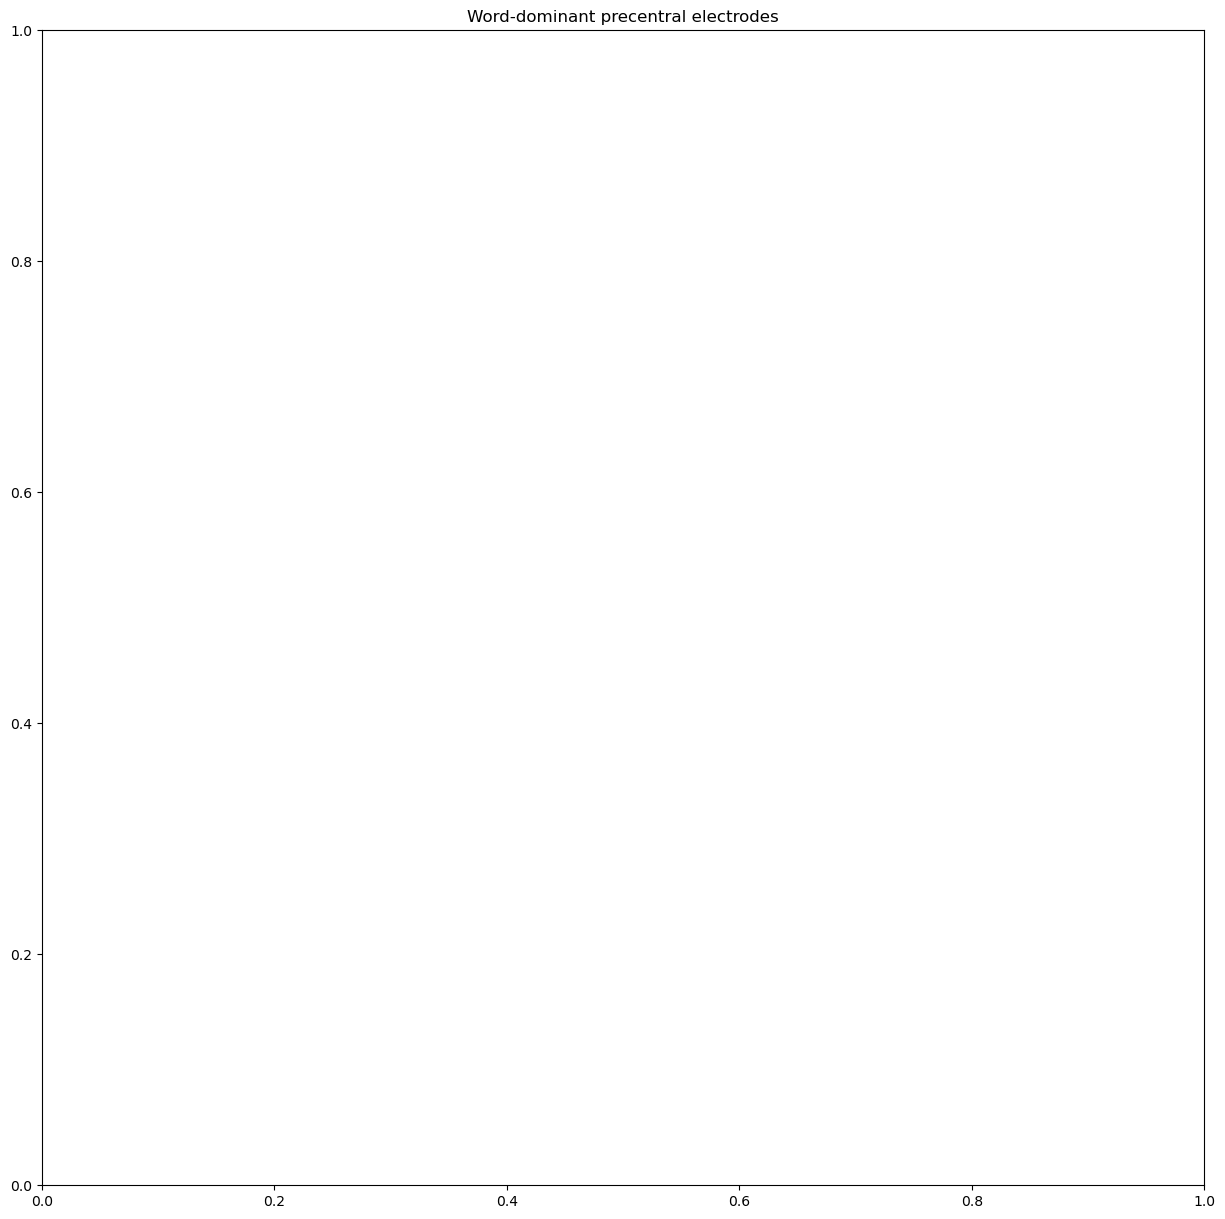

In [48]:
f, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Word-dominant precentral electrodes")
plot_trajectory([57, 107], "line", 20, ax=ax)

<Axes: title={'center': 'Word-dominant STG electrodes'}, xlabel='214', ylabel='230'>

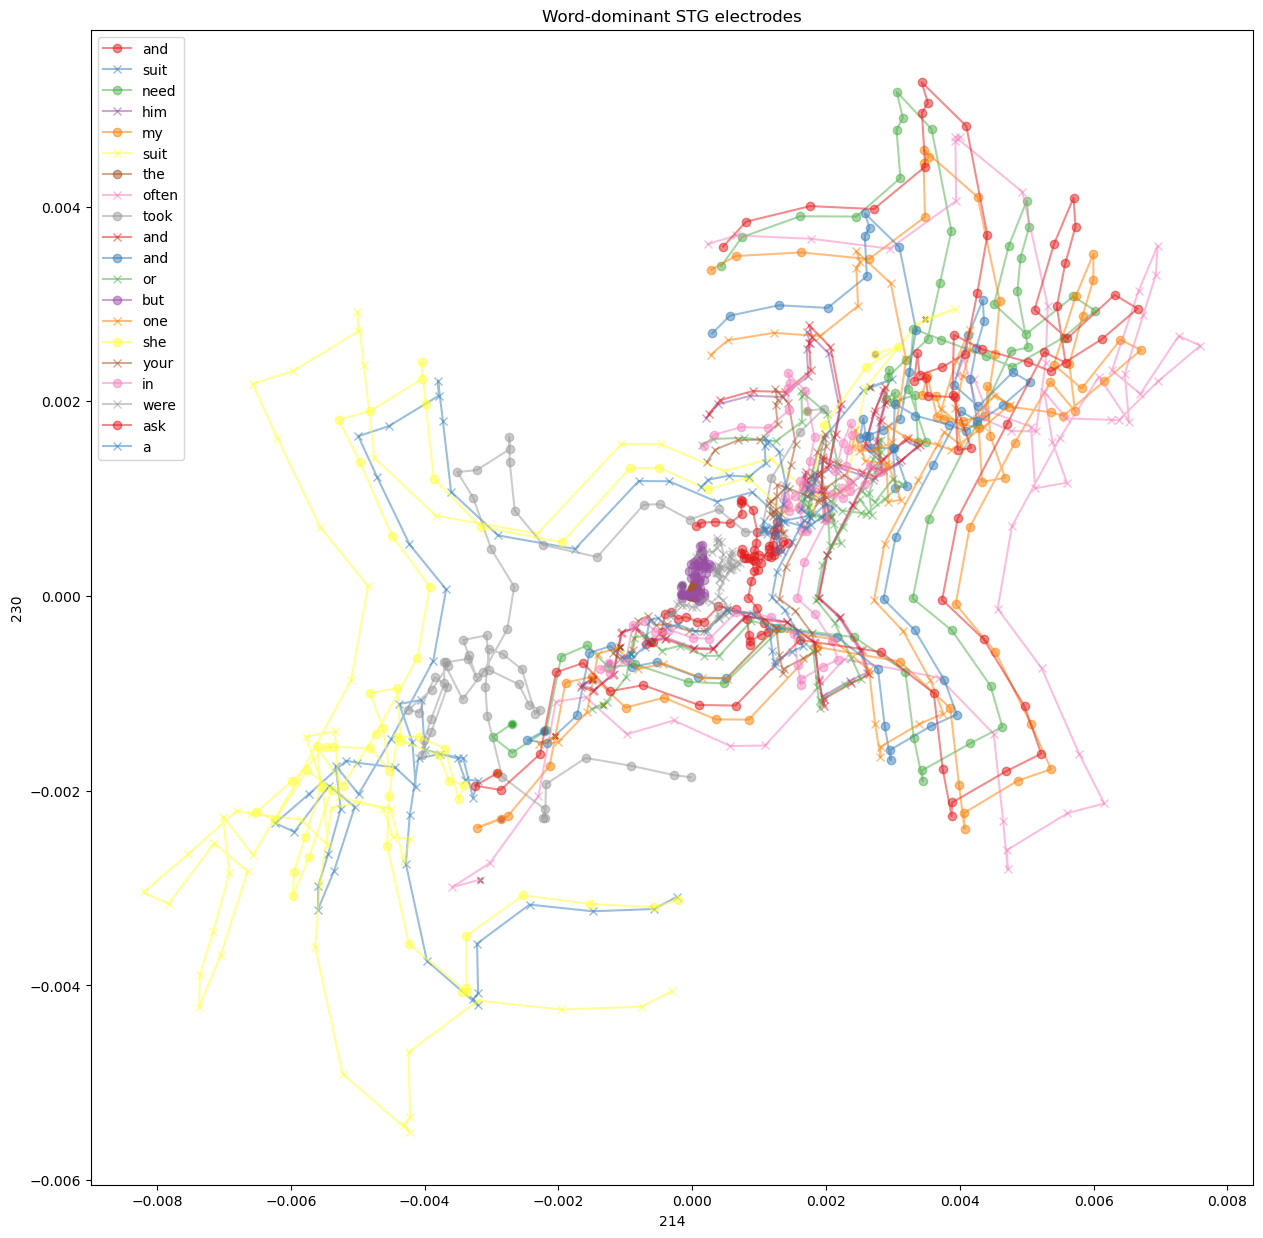

In [ ]:
ax = plt.subplots(figsize=(15, 15))[1]
ax.set_title("Word-dominant STG electrodes")
plot_trajectory([214, 230], "line", 20, ax=ax)

<Axes3D: title={'center': 'Word-dominant STG electrodes'}, xlabel='220', ylabel='214'>

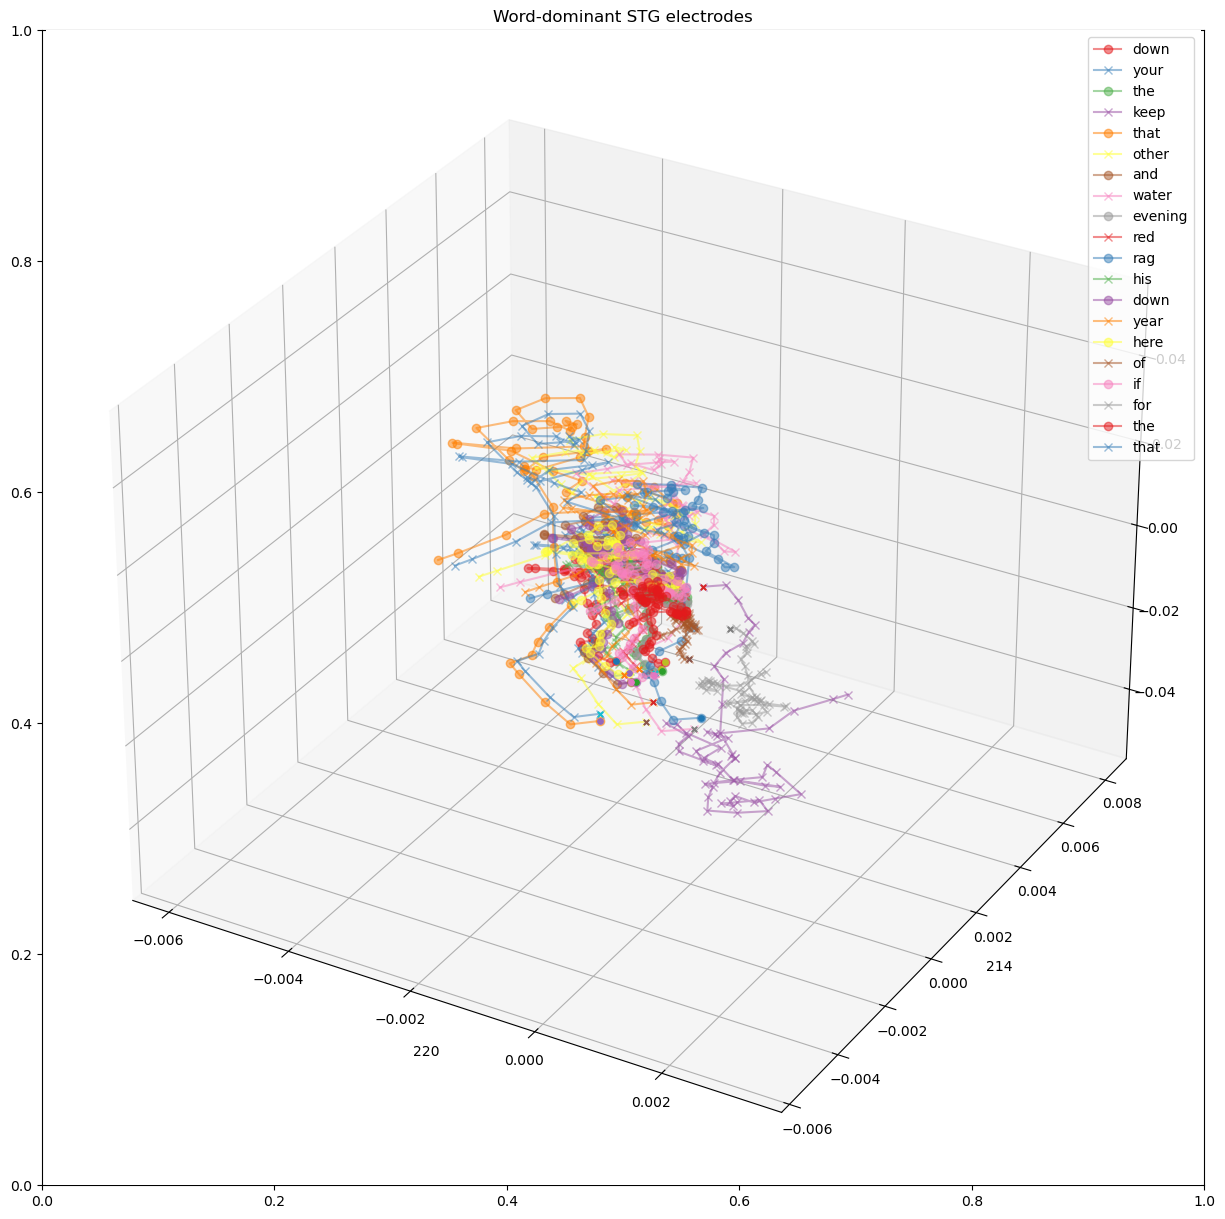

In [ ]:
ax = plt.subplots(figsize=(15, 15))[0].add_subplot(projection='3d')
ax.set_title("Word-dominant STG electrodes")
plot_trajectory([220, 214, 230], "line", 20, ax=ax)